In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 497.5 MB 23 kB/s 
     |████████████████████████████████| 462 kB 60.5 MB/s 
     |████████████████████████████████| 5.8 MB 37.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


     |████████████████████████████████| 497.5 MB 24 kB/s 


In [10]:
%pwd

'C:\\Users\\admin'

['all-dogs', 'Annotation']


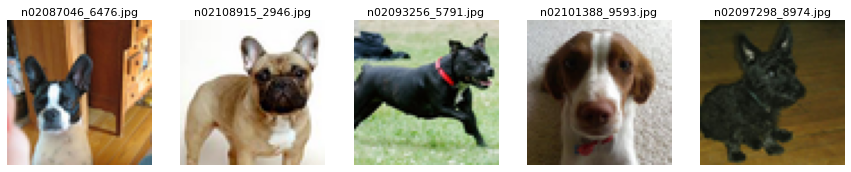

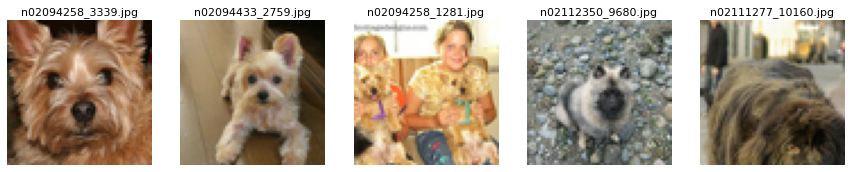

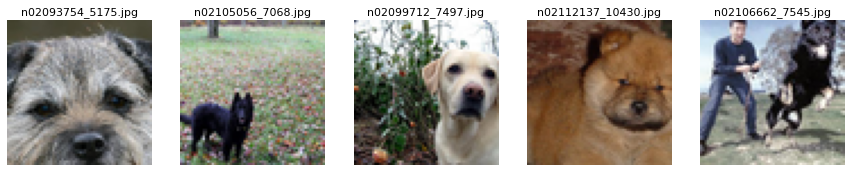

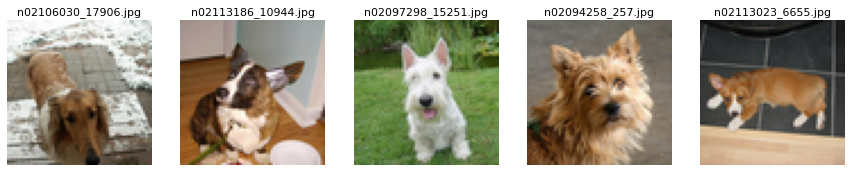

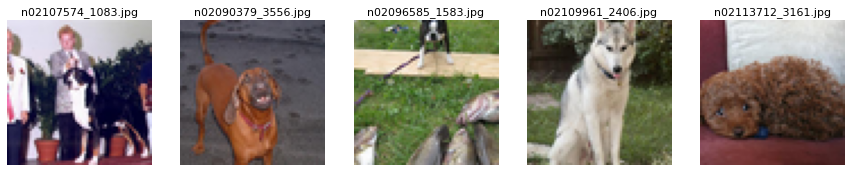

In [18]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = 'C:/Users/admin/input'
# if not ComputeLB: ROOT = '/input/'
print(os.listdir(ROOT))
IMAGES = os.listdir(ROOT + '/all-dogs/')
breeds = os.listdir(ROOT + '/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
                
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20000),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + '/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))  
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [19]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam

In [20]:
# BUILD GENERATIVE NETWORK
direct_input = Input((10000,))
x = Dense(2048, activation='elu')(direct_input)
x = Reshape((8,8,32))(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
decoder = Model(direct_input, decoded)
decoder.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
decoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              20482048  
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         36992     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)       

In [22]:
idx = np.random.randint(0,idxIn,10000)
train_y = imagesIn[idx,:,:,:]/255.
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1

In [29]:
lr = 0.01
for k in range(2):
    # annealer = LearningRateScheduler(lambda x: lr)
    print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
    h = decoder.fit(train_X, train_y, epochs = 2, batch_size=4096, verbose=0)
    if h.history['loss'][-1]<0.54: lr = 0.001

Epoch 10 /500 - loss = 0.544607400894165
Epoch 20 /500 - loss = 0.5445026159286499


Generate Random Dogs


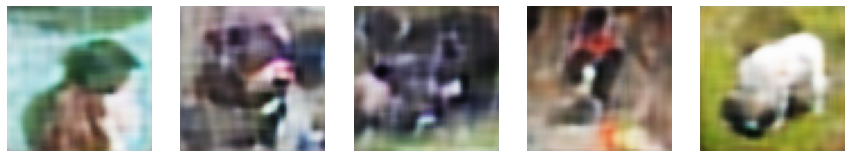

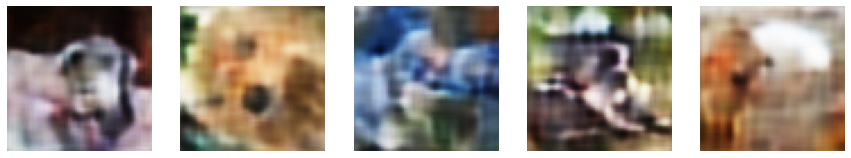

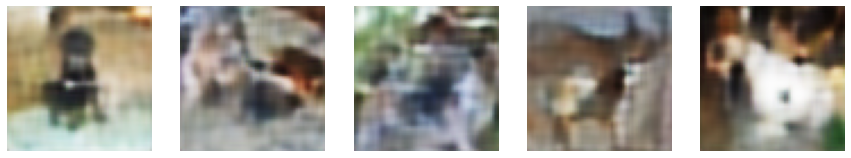

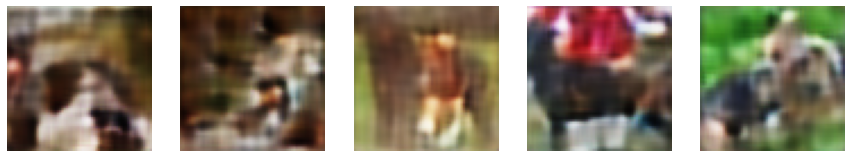

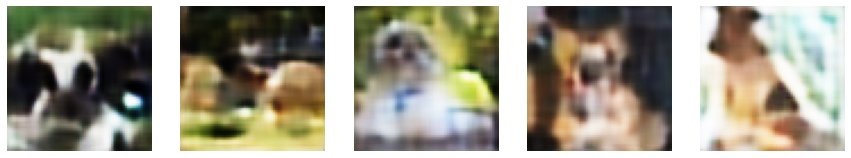

In [30]:
print('Generate Random Dogs')
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        xx[np.random.randint(10000)] = 0.75
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1, 10000)))
        img = Image.fromarray((255 * img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [33]:
decoder.save('C:/Users/admin/input')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: C:/Users/admin/input\assets


INFO:tensorflow:Assets written to: C:/Users/admin/input\assets


In [39]:
from tensorflow.keras.models import load_model

In [41]:
model = load_model('C:/Users/admin/input/')

Generate Random Dogs


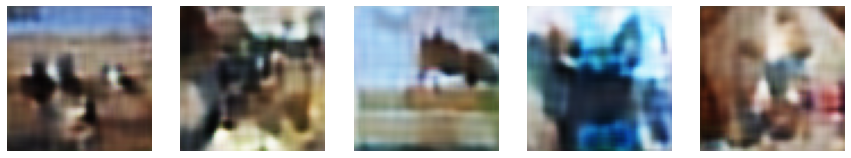

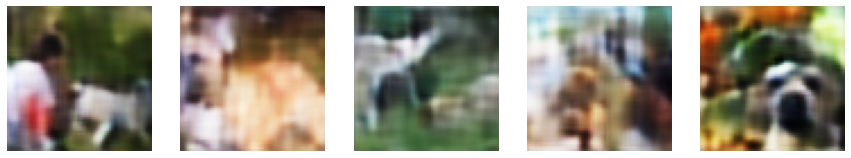

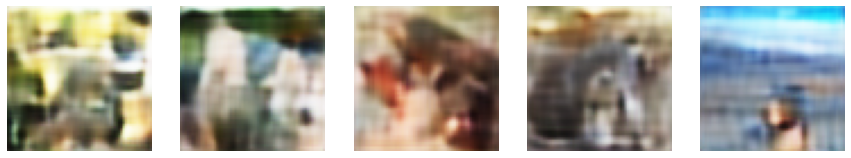

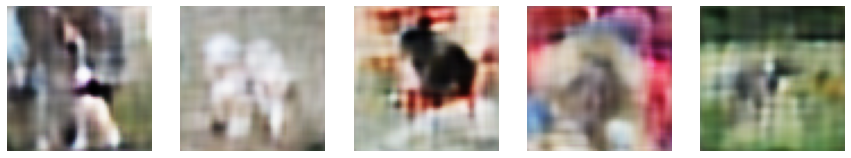

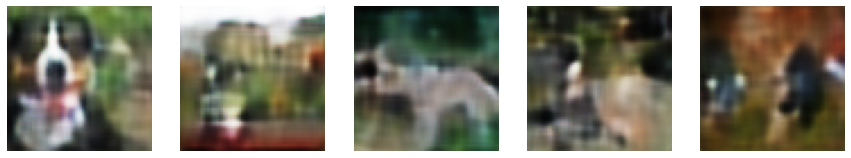

In [42]:
print('Generate Random Dogs')
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        xx[np.random.randint(10000)] = 0.75
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(1,5,j+1)
        img = model.predict(xx.reshape((-1, 10000)))
        img = Image.fromarray((255 * img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()